# TP LEARN 

## NMF for Audio Source Separation

Mathieu Lagrange

**Groupe** : Yassine Jamoud, Saâd Aziz Alaoui, Samy Haffoudhi

In [4]:
# deal with matrices
import numpy as np

# deal with audio data
import librosa as lr
from librosa import display

# handle display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# show loop progress
from tqdm.notebook import tqdm

# play audio
import IPython.display as ipd

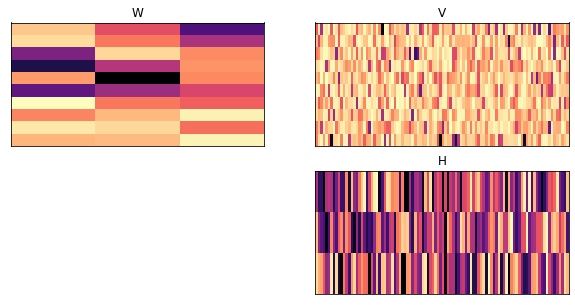

In [5]:
# utility function to display the decomposition of V into a product of W (dictionary) and H (activations)
def plotNmf(V, W, H):
    fig, axes = plt.subplots(2, 2)
    axes[1, 0].axis('off')
    lr.display.specshow(lr.amplitude_to_db(W), ax=axes[0, 0])
    lr.display.specshow(lr.amplitude_to_db(V), ax=axes[0, 1])
    lr.display.specshow(H, ax=axes[1, 1])
    axes[1, 1].sharex(axes[0, 1])
    axes[0, 0].set_title('W')
    axes[0, 1].set_title('V')
    axes[1, 1].set_title('H')
    
    plt.show()
    
plotNmf(np.random.rand(10, 100), np.random.rand(10, 3), np.random.rand(3, 100))

## NMF

Question: Implement the euclidean NMF algorithm using multiplicative update rules (see https://en.wikipedia.org/wiki/Non-negative_matrix_factorization section Algorithms). If W or H are given as parameters, they should not be updated during the optimization.

  0%|          | 0/100 [00:00<?, ?it/s]

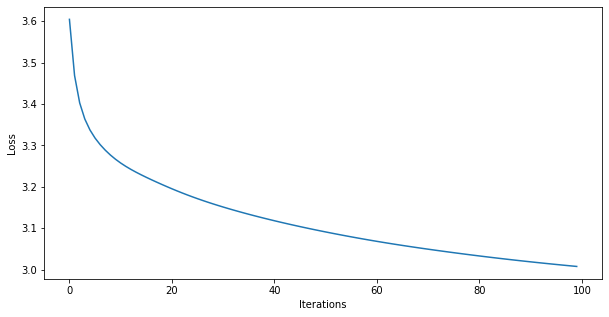

In [6]:
def nmf(V, R, L=100, W=None, H=None):
    eps = 10**(-12)
    K = V.shape[0]
    N = V.shape[1]
    w_fixed = False
    h_fixed = False
    if W is None:
        W = np.random.rand(K, R)
    else:
        w_fixed = True
    if H is None:
        H = np.random.rand(R, N)
    else:
        h_fixed = True
        
    eps_machine = np.finfo(np.float32).eps
    err = np.zeros((L))
    for it in tqdm(range(L)):
        # answer here
        if not h_fixed:
            H *= (W.T @ V / (eps + W.T @ W @ H))
        if not w_fixed:
            W *= (V @ H.T / (eps + W @ H @ H.T))
        #####
        V_approx = W.dot(H)
        err[it] = np.linalg.norm(V-V_approx, ord=2)
    return W, H, err

# check performance on random matrix
W, H, err = nmf(np.abs(np.random.random((10, 100))), 5)
plt.plot(err)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## Load monophonic audio

In [7]:
drumFileName = 'sounds/drums.wav'
d, sr = lr.load(drumFileName)

ipd.Audio(d, rate=sr)

## Spectral analysis / synthesis

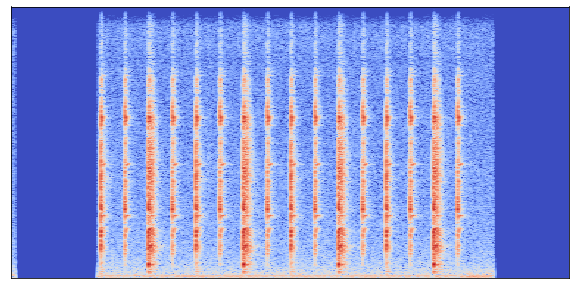

In [9]:
# short term Fourier transform (complex data)
D = lr.stft(d)
# magnitude spectrum (spectrogram)
mD = np.abs(D)
# phase spectrum
aD = np.angle(D)

# display the spectrogram in deciBels
lr.display.specshow(lr.amplitude_to_db(mD))

# synthesize the complex spectrum from the magnitude and phase spectra
DE = mD*np.exp(1j*aD)
# inverse short term Fourier transform to retrieve the time signal
de = lr.istft(DE)

# as you can here, this is a perfect reconstruction (de=d)
ipd.Audio(de, rate=sr)

### perform NMF on magnitude spectrogram with 3 components

In [10]:
# set the random seed to have replicable performance of the NMF
np.random.seed(0)

Wd, Hd, err = nmf(mD, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

### show dictionnary and activations

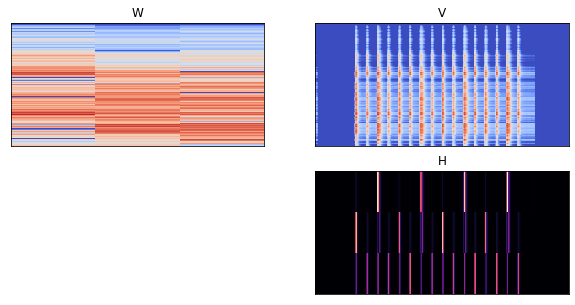

In [11]:
plotNmf(Wd @ Hd, Wd, Hd)

### identify bass drum

On écoute les reconstructions obtenues pour les 3 choix possibles et on garde celui qui contient l"information à extraire

In [25]:
indice = 2 # déterminé après écoute

w = Wd[:,indice]
h = Hd[indice]

h = h.reshape((-1,h.shape[0]))
w = w.reshape((w.shape[0],-1)) 

V = np.matmul(w,h)

### predict bass drum magnitude spectral data

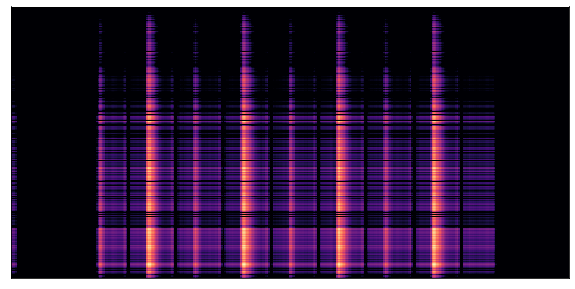

In [26]:
BDm = lr.display.specshow(lr.amplitude_to_db(V))

### synthesis

In [27]:
DE = V*np.exp(1j*aD)
de = lr.istft(DE)
ipd.Audio(de, rate=sr)

La NMF nous  a bien d'extraire la source recherchée.

## Load polyphonic audio

This is a piano performance composed of 3 parts, one is played détaché, one is played arpegiatto, and the other is made of chords.

Describe the performance.

How many tones are played ?

How many pitches are used ?

What should be the minimal order of the NMF to decompose this performance


**Answer**

À l'écoute du son, on distingue bien les 3 parties ainsi que 3 notes différentes.
Chaque partie est caracterisée par un espacement différent entre les 3 notes.

Il faut donc utiliser un dictionaire formé d'au moins 3 éléments.

In [175]:
pianoFileName = 'sounds/piano.wav'
p, sr = lr.load(pianoFileName)

limits = [139, 268]

ipd.Audio(p, rate=sr)

## Spectral analysis / synthesis

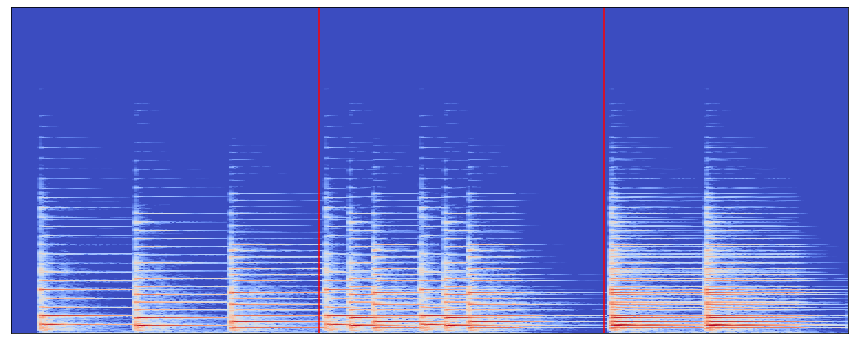

In [176]:
P = lr.stft(p)
mP = np.abs(P)
aP = np.angle(P)

plt.figure(figsize=(15,6))
lr.display.specshow(lr.amplitude_to_db(mP))
plt.plot(np.ones(2)*limits[0], [0, 1024], 'r')
plt.plot(np.ones(2)*limits[1], [0, 1024], 'r')
plt.savefig("spectre")
plt.show()

### Learn on whole, decode whole

perform the nmf decomposition on the whole piano performance.

Interpret the H matrix.

In [177]:
np.random.seed(42)

Wp, Hp, err = nmf(mP, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

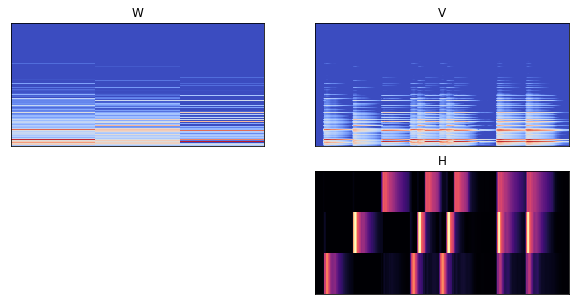

In [178]:
plotNmf(Wp @ Hp, Wp, Hp)

In [179]:
Pr = Wp @ Hp * np.exp(1j*aP)
pr = lr.istft(Pr)
ipd.Audio(pr, rate=sr)

On obtient la matrice H, matrice d'activations. Cette matrice nous permet en particulier de distinguer les distiguer les différentes parties. Par exemple, on note bien l'absence de recouvrements pour la première partie tandis que pour la dernière partie le recouvrement est maximal.

### Learn on "détaché", decode whole

Estimate the dictionnary using only the first part of the performance.

Estimate the activations using this dictionnary for the whole performance.

Is the decomposition of good quality ?

In [180]:
ind_1 = int(limits[0]*p.shape[0]/P.shape[1])
ind_2 = int(limits[1]*p.shape[0]/P.shape[1])

p_1 = p[:ind_1]

ipd.Audio(p_1, rate=sr)

In [181]:
P = lr.stft(p_1)
mP_new = np.abs(P)

np.random.seed(42)
Wp_new, _, _ = nmf(mP_new, 3)
_, Hp_new, _ = nmf(mP, 3, W=Wp)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

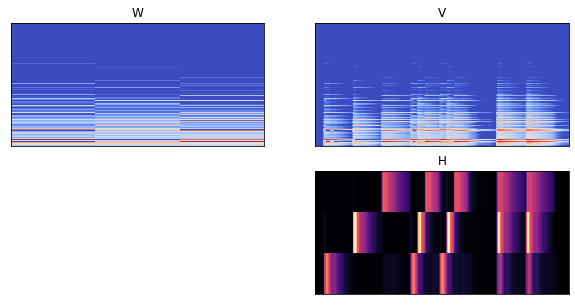

In [182]:
plotNmf(Wp_new @ Hp_new, Wp_new, Hp_new)

In [183]:
Pr = Wp_new @ Hp_new * np.exp(1j*aP)
pr = lr.istft(Pr)
ipd.Audio(pr, rate=sr)

La reconstruction est de bonne qualité. En effet pour la première partie on peut distinguer les 3 notes utilisées puisqu'il n y'a pas de reouvrement. On obtient les même résultats que pour le calcul sur le son entier.

### Learn on appregiato, decode whole

Estimate the dictionnary using only the second part of the performance.

Estimate the activations using this dictionnary for the whole performance.

Is the decomposition of good quality ?

In [184]:
p_2 = p[ind_1:ind_2]
ipd.Audio(p_2, rate=sr)

In [185]:
P = lr.stft(p_2)
mP_new = np.abs(P)

np.random.seed(42)
Wp_new, _, _ = nmf(mP_new, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

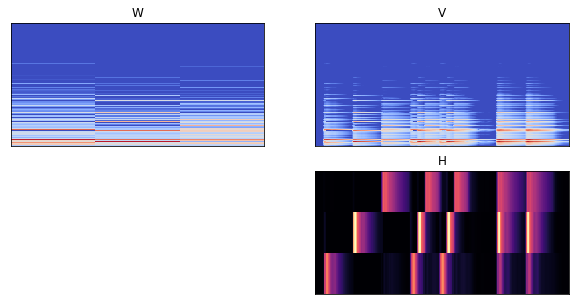

In [186]:
plotNmf(Wp_new @ Hp_new, Wp_new, Hp_new)

In [187]:
Pr = Wp_new @ Hp_new * np.exp(1j*aP)
pr = lr.istft(Pr)
ipd.Audio(pr, rate=sr)

Cette fois, la reconstruction est de moins bonne qualité. En effet, à cause du recouvrement partiel on ne peut pas identifier exactement les 3 notes comme précedemment. 

### Learn on chords, decode whole

Estimate the dictionnary using only the last part of the performance.

Estimate the activations using this dictionnary for the whole performance.

In [188]:
p_3 = p[ind_2:]
ipd.Audio(p_3, rate=sr)

In [141]:
P = lr.stft(p_3)
mP_new = np.abs(P)

np.random.seed(42)

Wp_new, _, _ = nmf(mP_new, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

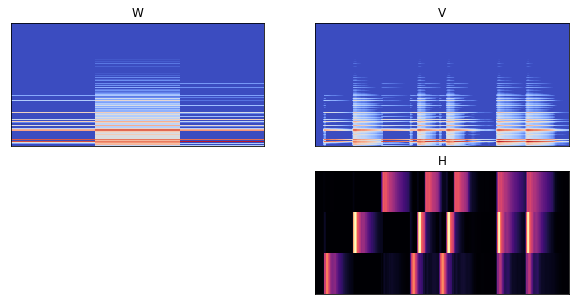

In [142]:
plotNmf(Wp_new @ Hp_new, Wp_new, Hp_new)

In [143]:
Pr = Wp_new @ Hp_new * np.exp(1j*aP)
pr = lr.istft(Pr)
ipd.Audio(pr, rate=sr)

La reconstruction est d'encore moins bonne qualité, le recouvremeent étant cette fois total. On note qu'on reconnait quand même le son grâce à la matrice H qui conserve le rythme du son.

## Separating sources from a mix of piano and drums


In [144]:
# mix the piano and the drum
m = p + d
ipd.Audio(m, rate=sr)

## Spectral analysis / synthesis

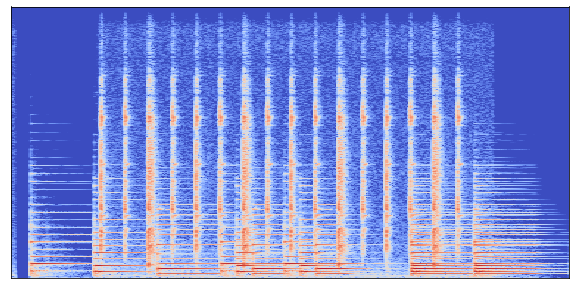

In [145]:
M = lr.stft(m)
mM = np.abs(M)
aM = np.angle(M)

lr.display.specshow(lr.amplitude_to_db(mM))

ME = mM*np.exp(1j*aM)
me = lr.istft(ME)

ipd.Audio(me, rate=sr)

## Consider priors to separate the piano and the drums

build a dictionnary that combines the dictionnaray for the piano source and the drum source. In this case, the selectors are deterministicly determined.

In [146]:
mWp = np.c_[Wp, Wd]
np.random.seed(0)
_, mHp, _ = nmf(mM, 6, W=mWp)

  0%|          | 0/100 [00:00<?, ?it/s]

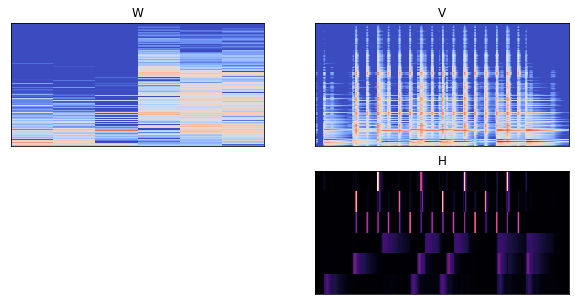

In [147]:
plotNmf(mWp @ mHp, mWp, mHp)

Select the elements of the dictionary that corresponds to the piano to perform the separation

In [148]:
pianoSelector = range(3)

mPM = mWp[:, pianoSelector] @ mHp[pianoSelector, :]
PM = mPM*np.exp(1j*aM)
pm = lr.istft(PM)

ipd.Audio(pm, rate=sr)

Select the elements of the dictionary that corresponds to the drums to perform the separation

In [155]:
drumSelector = range(3, 6)

mDM = np.matmul(mWp[:, drumSelector], mHp[drumSelector, :])
DM = mDM*np.exp(1j*aM)
dm = lr.istft(DM)

ipd.Audio(dm, rate=sr)

On obtient de bons résultats en utilisant l'a priori sur le dictionnaire. On arrive à séparer le piano de la batterie et on obtient des signaux de bonne qualité même si on note quand même la présence de quelques artefacts.

## Separate the piano and the drums with no priors

perform the nmf with no prior, and manually choose the selectors.

Use those selectors to synthesize the piano and drum source.

  0%|          | 0/100 [00:00<?, ?it/s]

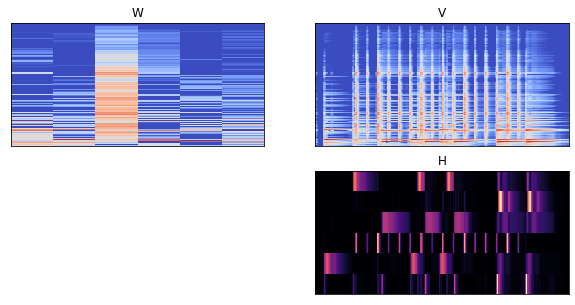

In [156]:
np.random.seed(0)

W, H, _ = nmf(mM, 6)
plotNmf(W @ H, W, H)

In [164]:
pianoSelector = [0, 1, 3, 4, 5]
Vp = W[:, pianoSelector] @ H[pianoSelector, :]
P = Vp*np.exp(1j*aM)
p = lr.istft(P)
ipd.Audio(p, rate=sr)

In [165]:
drumSelector = [2]
Vd = W[:, drumSelector] @ H[drumSelector, :]
P = Vd*np.exp(1j*aM)
p = lr.istft(P)
ipd.Audio(p, rate=sr)

Cette fois, la reconstruction est légèrement moins bonne puisqu'on ne dispose pas déjà du dictionnaire qu'il convient alors de déterminer à partir du signal melangé. Les résultats restent quand même très satisfaisants.